# $R_t$ usando EpiEstim no R
*Code by: Francisco Nogueira*

### <font color=red>**AVISO:**</font>
O resultado da função `estimate_R` é uma lista com 3 parâmetros, o parâmetro R contém a série de $R_t$ calculado, quando usamos a função `plot()` do EpiEstim, ela recebe essa lista e se quisermos só o plot do $R_t$, podemos passálo como argumento da função: `plot(x,'R')` sendo x a lista retornada por `estimate_R`, entretanto, como queremos um dataframe com a série de $R_t$ para todos os estado, salvamos só o argumento `x$R`, isso faz com que a função `plot()` não possa ser mais usada pros dados nesse formato. A alternativa é usar a função de [`plots.plot_rt_wrapper()`](https://github.com/ImpulsoGov/farolcovid/blob/master/src/plots.py#L118) feita em Python

## Import packages

In [2]:
# install.packages("readxl")
# install.packages("ggplot2")
# install.packages("EpiEstim")
# install.packages("tidyverse")
# install.packages("RCurl")
# install.packages("dplyr")
# install.packages("zoo")
# install.packages("TTR")

In [3]:
library(TTR)
library(readxl)
library(ggplot2)
library(EpiEstim)
#library(tidyverse)
library(RCurl)
library(dplyr)
library(zoo)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## Import data

In [4]:
df_cities_cases = read.csv(text = getURL("http://datasource.coronacidades.org/br/cities/cases/full"))
# head(df_cities_cases)

In [5]:
df_farol = read.csv(text = getURL("http://datasource.coronacidades.org/br/states/farolcovid/main"))
# head(df_farol)

## Treat data

In [6]:
df_state_cases = df_cities_cases %>% select("state","city_id","last_updated","daily_cases", "confirmed_cases") %>% #Seleciona as colunas utilizadas pelo modelo
      filter(!is.na(daily_cases)) %>% # Filtra os dias para que não haja NA
      group_by(state,last_updated) %>% # Agrupa os dados por estado e data
      summarize(new_cases = sum(daily_cases), total_cases = sum(confirmed_cases)) # Soma casos dos municipios

# Altera nomes das colunas
names(df_state_cases)[names(df_state_cases) == 'state'] <- 'state_id'
names(df_state_cases)[names(df_state_cases) == 'last_updated'] <- 'dates'

# Converção dos formatos dos dados
df_state_cases$state_id = as.character(df_state_cases$state_id)
df_state_cases$dates = as.Date(df_state_cases$dates)

# Adicionando a coluna de população ao df
df_state_cases = merge(x = df_state_cases, 
                       y = as.data.frame((df_farol %>% select(state_id, population))),
                       by = "state_id", all = TRUE)

# Média móvel de nivis casos (7 dias)
df_state_cases = df_state_cases %>% 
                    group_by(state_id) %>%
                    mutate(new_cases_mavg = runMean(new_cases, 7))

# Incidencia: Infectados por 100k/hab. 
df_state_cases$I = (100e3 * df_state_cases$new_cases_mavg)/df_state_cases$population

# Filtra início da série
df_state_cases = df_state_cases %>%
                    filter(!is.na(I)) %>%
                    filter(total_cases >= 15)

head(df_state_cases)

`summarise()` regrouping output by 'state' (override with `.groups` argument)



state_id,dates,new_cases,total_cases,population,new_cases_mavg,I
<chr>,<date>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
AC,2020-03-24,4,21,881935,2.571429,0.2915667
AC,2020-03-25,2,23,881935,2.857143,0.3239630
AC,2020-03-26,0,23,881935,2.714286,0.3077648
AC,2020-03-27,2,25,881935,2.571429,0.2915667
AC,2020-03-28,0,25,881935,2.000000,0.2267741
AC,2020-03-29,6,31,881935,2.857143,0.3239630


### Check values

In [7]:
df_state_cases %>% filter(is.na(I))

state_id,dates,new_cases,total_cases,population,new_cases_mavg,I
<chr>,<date>,<dbl>,<dbl>,<int>,<dbl>,<dbl>


In [8]:
df_state_cases %>% filter(I < 0)

state_id,dates,new_cases,total_cases,population,new_cases_mavg,I
<chr>,<date>,<dbl>,<dbl>,<int>,<dbl>,<dbl>


## $R_t$ for a single state

In [9]:
state_select = "SP"

Adding missing grouping variables: `state_id`

Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

Warning message in estimate_R_func(incid = incid, method = method, si_sample = si_sample, :
“You're estimating R too early in the epidemic to get the desired
            posterior CV.”


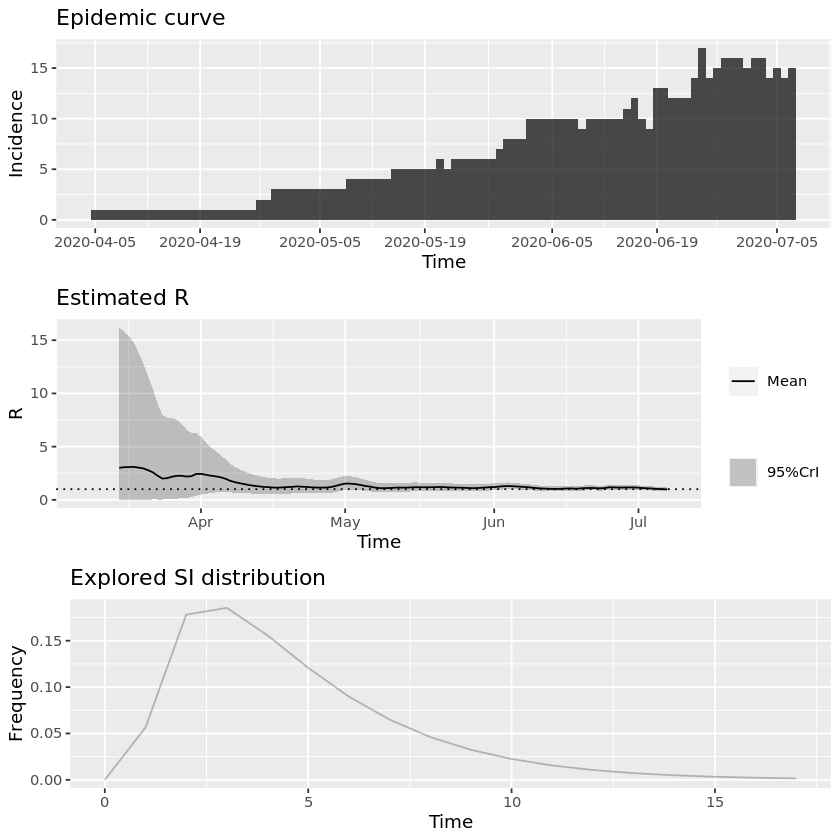

In [10]:
x = df_state_cases %>% filter(state_id == state_select) %>% select(dates, I)

# Para rodar dia a dia, por default ele roda 7 dias
t_start = seq(2, nrow(x)-1)
t_end = t_start + 1

rt = estimate_R(x, 
                method="parametric_si",
                config = make_config(list(
                    mean_si = 4.7,
                    std_si = 2.9,
                    mean_prior=3
#                     t_start = t_start,
#                     t_end = t_end
                )))
plot(rt)

In [11]:
rt$R

t_start,t_end,Mean(R),Std(R),Quantile.0.025(R),Quantile.0.05(R),Quantile.0.25(R),Median(R),Quantile.0.75(R),Quantile.0.95(R),Quantile.0.975(R)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,8,3.005884,4.5789696,0.001009198,0.005043209,0.2156879,1.183887,3.863438,12.169721,16.160200
3,9,3.061740,4.4787386,0.001885579,0.008315366,0.2674114,1.308658,4.002828,12.047126,15.862942
4,10,3.079232,4.3318499,0.003242102,0.012794978,0.3197272,1.413900,4.081801,11.784479,15.395771
5,11,3.092917,4.1386823,0.006081953,0.021076960,0.3925263,1.542605,4.159601,11.420204,14.775976
6,12,3.028239,3.8611322,0.010237537,0.031678138,0.4571567,1.621549,4.116892,10.799461,13.847926
7,13,2.954151,3.5609828,0.017536499,0.048215180,0.5339294,1.701892,4.053287,10.116940,12.843393
8,14,2.779335,3.2050421,0.024575391,0.062132987,0.5705695,1.685506,3.832591,9.218935,11.614662
9,15,2.583702,2.8589724,0.032045504,0.075444369,0.5910614,1.636195,3.573882,8.319380,10.409616
10,16,2.259294,2.4802401,0.029805052,0.069263490,0.5271615,1.442050,3.126514,7.233497,9.039177


## $R_t$ for all states

In [12]:
# Gera a tabela dos estados
rt_cori_serie = 0
states = as.vector(unique(df_state_cases$state_id)) 

for(st in states){
    rt = estimate_R(df_state_cases %>% filter(state_id == st) %>% select(dates, I), 
                    method="parametric_si",
                    config = make_config(list(
                        mean_si = 4.7,
                        std_si = 2.9,
                        mean_prior=3))
                   )
    
    rtx = bind_cols(state_id=st,rt$R)
    
    if(rt_cori_serie == 0){
        rt_cori_serie = rtx
            }
    else{
        rt_cori_serie = bind_rows(rt_cori_serie,rtx)
    }
}

Adding missing grouping variables: `state_id`

Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

Warning message in estimate_R_func(incid = incid, method = method, si_sample = si_sample, :
“You're estimating R too early in the epidemic to get the desired
            posterior CV.”
Adding missing grouping variables: `state_id`

Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

Warning message in estimate_R_func(incid = incid, method = method, si_sample = si_sample, :
“You're estimating R too early in the epidemic to get the desired
            posterior CV.”
Warning message in if (rt_cori_serie == 0) {:
“the condition has length > 1 and only the first element will be used”
Adding missing grouping variables: `state_id`

Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

Warning message

Adding missing grouping variables: `state_id`

Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

Warning message in estimate_R_func(incid = incid, method = method, si_sample = si_sample, :
“You're estimating R too early in the epidemic to get the desired
            posterior CV.”
Warning message in if (rt_cori_serie == 0) {:
“the condition has length > 1 and only the first element will be used”
Adding missing grouping variables: `state_id`

Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

Warning message in estimate_R_func(incid = incid, method = method, si_sample = si_sample, :
“You're estimating R too early in the epidemic to get the desired
            posterior CV.”
Warning message in if (rt_cori_serie == 0) {:
“the condition has length > 1 and only the first element will be used”
Adding missing grouping variables: `state_id`

Default config wi

In [13]:
head(rt_cori_serie)

,state_id,t_start,t_end,Mean(R),Std(R),Quantile.0.025(R),Quantile.0.05(R),Quantile.0.25(R),Median(R),Quantile.0.75(R),Quantile.0.95(R),Quantile.0.975(R)
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AC,2,8,2.062493,1.3134611,0.3368371,0.4658047,1.0966313,1.791375,2.735887,4.585568,5.319595
2,AC,3,9,1.668421,1.0731304,0.2654782,0.3690016,0.8792980,1.444839,2.216409,3.731812,4.334114
3,AC,4,10,1.458377,0.9380301,0.2320562,0.3225466,0.7686000,1.262943,1.937378,3.262001,3.788477
4,AC,5,11,1.334455,0.8583229,0.2123377,0.2951389,0.7032898,1.155627,1.772753,2.984819,3.466559
5,AC,6,12,1.291097,0.8195238,0.2126477,0.2935792,0.6884544,1.122452,1.711801,2.864853,3.322198
6,AC,7,13,1.189486,0.7702577,0.1859101,0.2593160,0.6230902,1.027992,1.581735,2.671481,3.105061


#### Distribution of last $Rt$ value for all states

In [14]:
rt_cori_last = rt_cori_serie %>% group_by(state_id) %>% filter(t_start == max(t_start)) %>% arrange(`Mean(R)`)

# Altera nomes das colunas
rt_cori_last = rt_cori_last %>% rename(
                         rt_cori_mean = `Mean(R)`,
                         rt_cori_low = `Quantile.0.05(R)`,
                         rt_cori_high = `Quantile.0.95(R)`,
                    )

# Tamanho do intervalo
rt_cori_last$rt_cori_ic_size = rt_cori_last$rt_cori_high - rt_cori_last$rt_cori_low

rt_cori_last

state_id,t_start,t_end,rt_cori_mean,Std(R),Quantile.0.025(R),rt_cori_low,Quantile.0.25(R),Median(R),Quantile.0.75(R),rt_cori_high,Quantile.0.975(R),rt_cori_ic_size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AP,90,96,0.4746934,0.03198657,0.4140667,0.4233338,0.4527452,0.4739752,0.4958588,0.5285032,0.5394018,0.1051695
RJ,111,117,0.8336501,0.10463999,0.6412682,0.6693165,0.7608906,0.8292761,0.9016432,1.0129052,1.0508843,0.3435887
RN,98,104,0.8877089,0.05983612,0.7742979,0.7916330,0.8466509,0.8863649,0.9273019,0.9883697,1.0087577,0.1967367
RO,87,93,0.8987654,0.06158313,0.7821097,0.7999252,0.8564973,0.8973593,0.9395008,1.0024023,1.0234118,0.2024771
PA,97,103,0.9118626,0.07300957,0.7743810,0.7951865,0.8616143,0.9099148,0.9599879,1.0351830,1.0604125,0.2399965
AL,90,96,0.9629098,0.07476520,0.8219460,0.8433196,0.9114825,0.9609754,1.0122286,1.0890984,1.1148654,0.2457788
PB,94,100,0.9682579,0.06952127,0.8367864,0.8568129,0.9205039,0.9665945,1.0141988,1.0853769,1.1091816,0.2285640
AC,100,106,0.9756465,0.07335741,0.8371618,0.8582004,0.9252169,0.9738085,1.0240728,1.0993621,1.1245751,0.2411617
SP,116,122,0.9936902,0.09495617,0.8163171,0.8428273,0.9281022,0.9906672,1.0559834,1.1548652,1.1882407,0.3120379


## Compare to current (Kevin's approach)

In [15]:
df_rt = read.csv(text = getURL("http://datasource.coronacidades.org/br/states/rt"))

# Altera nomes das colunas
df_rt = df_rt %>% rename(state_id = state, 
                         dates = last_updated, 
                         rt_kevin_mean = Rt_most_likely,
                         rt_kevin_low = Rt_low_95,
                         rt_kevin_high = Rt_high_95,
                        )

# Converção dos formatos dos dados
df_rt$state_id = as.character(df_rt$state_id)
df_rt$dates = as.Date(df_rt$dates)

# Tamanho do intervalo
df_rt$rt_kevin_ic_size = df_rt$rt_kevin_high - df_rt$rt_kevin_low
head(df_rt)

,state_id,dates,rt_kevin_mean,rt_kevin_low,rt_kevin_high,data_last_refreshed,rt_kevin_ic_size
,<chr>,<date>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,AC,2020-04-12,3.00,0.67,7.84,2020-07-08 18:11:21,7.17
2,AC,2020-04-13,1.93,0.73,3.19,2020-07-08 18:11:21,2.46
3,AC,2020-04-14,1.90,0.91,2.85,2020-07-08 18:11:21,1.94
4,AC,2020-04-15,1.92,1.06,2.70,2020-07-08 18:11:21,1.64
5,AC,2020-04-16,2.04,1.29,2.71,2020-07-08 18:11:21,1.42
6,AC,2020-04-17,2.13,1.48,2.72,2020-07-08 18:11:21,1.24


In [24]:
rt_kevin_last = df_rt %>% group_by(state_id) %>% filter(dates == max(dates)) %>% arrange(rt_kevin_mean)

rt_compare = merge(x=rt_cori_last, 
      y=rt_kevin_last, 
      by="state_id") %>% select("state_id", "rt_cori_mean", "rt_cori_ic_size", 
                                "rt_kevin_mean", "rt_kevin_ic_size") %>% arrange(rt_cori_mean)

rt_compare$is_cori_mean_greater = rt_compare$rt_cori_mean > rt_compare$rt_kevin_mean
rt_compare$is_cori_ic_greater = rt_compare$rt_cori_ic_size > rt_compare$rt_kevin_ic_size

rt_compare

state_id,rt_cori_mean,rt_cori_ic_size,rt_kevin_mean,rt_kevin_ic_size,is_cori_mean_greater,is_cori_ic_greater
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
AP,0.4746934,0.1051695,0.63,0.12,FALSE,FALSE
RJ,0.8336501,0.3435887,0.79,0.06,TRUE,TRUE
RN,0.8877089,0.1967367,1.00,0.09,FALSE,TRUE
RO,0.8987654,0.2024771,0.99,0.11,FALSE,TRUE
PA,0.9118626,0.2399965,0.87,0.07,TRUE,TRUE
AL,0.9629098,0.2457788,0.91,0.10,TRUE,TRUE
PB,0.9682579,0.2285640,0.91,0.10,TRUE,TRUE
AC,0.9756465,0.2411617,0.97,0.14,TRUE,TRUE
SP,0.9936902,0.3120379,0.99,0.05,TRUE,TRUE


In [25]:
table(rt_compare$is_cori_mean_greater)


FALSE  TRUE 
   14    13 

In [26]:
table(rt_compare$is_cori_ic_greater)


FALSE  TRUE 
    1    26 

In [27]:
write.csv(rt_compare,"rt_compare_epiestim.csv")

## Análise individual da série

In [30]:
st = 'AP'
t = rt_cori_serie %>% filter(state_id==st)
t[(nrow(t)-15):nrow(t),]

,state_id,t_start,t_end,Mean(R),Std(R),Quantile.0.025(R),Quantile.0.05(R),Quantile.0.25(R),Median(R),Quantile.0.75(R),Quantile.0.95(R),Quantile.0.975(R)
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
74,AP,75,81,1.3080014,0.05365817,1.2049334,1.2210106,1.2714207,1.3072677,1.3437823,1.3974948,1.4152385
75,AP,76,82,1.4026026,0.05441165,1.2979708,1.3143194,1.3655291,1.4018990,1.4389092,1.4932857,1.5112324
76,AP,77,83,1.4620569,0.05384750,1.3584085,1.3746273,1.4253860,1.4613959,1.4980072,1.5517412,1.5694617
77,AP,78,84,1.4705613,0.05194266,1.3705043,1.3861789,1.4352011,1.4699498,1.5052548,1.5570296,1.5740935
78,AP,79,85,1.4488966,0.04938790,1.3537023,1.3686290,1.4152861,1.4483354,1.4818953,1.5310782,1.5472796
79,AP,80,86,1.3565144,0.04575872,1.2682998,1.2821357,1.3253766,1.3559999,1.3870914,1.4326481,1.4476528
80,AP,81,87,1.2718488,0.04256979,1.1897712,1.2026471,1.2428829,1.2713739,1.3002970,1.3426705,1.3566253
81,AP,82,88,1.0940129,0.03820406,1.0204059,1.0319404,1.0680080,1.0935682,1.1195331,1.1576023,1.1701470
82,AP,83,89,0.9081227,0.03401838,0.8426630,0.8529013,0.8849520,0.9076980,0.9308304,0.9647931,0.9759962


In [36]:
df_single_state = df_state_cases %>% filter(state_id==st)
df_single_state

state_id,dates,new_cases,total_cases,population,new_cases_mavg,I
<chr>,<date>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
AP,2020-04-03,7,19,845731,2.285714,0.2702649
AP,2020-04-04,9,28,845731,3.428571,0.4053974
AP,2020-04-05,1,30,845731,3.000000,0.3547227
AP,2020-04-06,7,39,845731,4.000000,0.4729636
AP,2020-04-07,12,51,845731,5.428571,0.6418792
AP,2020-04-08,56,107,845731,13.285714,1.5709149
AP,2020-04-09,3,110,845731,13.571429,1.6046980
AP,2020-04-10,56,166,845731,20.571429,2.4323844
AP,2020-04-11,27,193,845731,23.142857,2.7364324


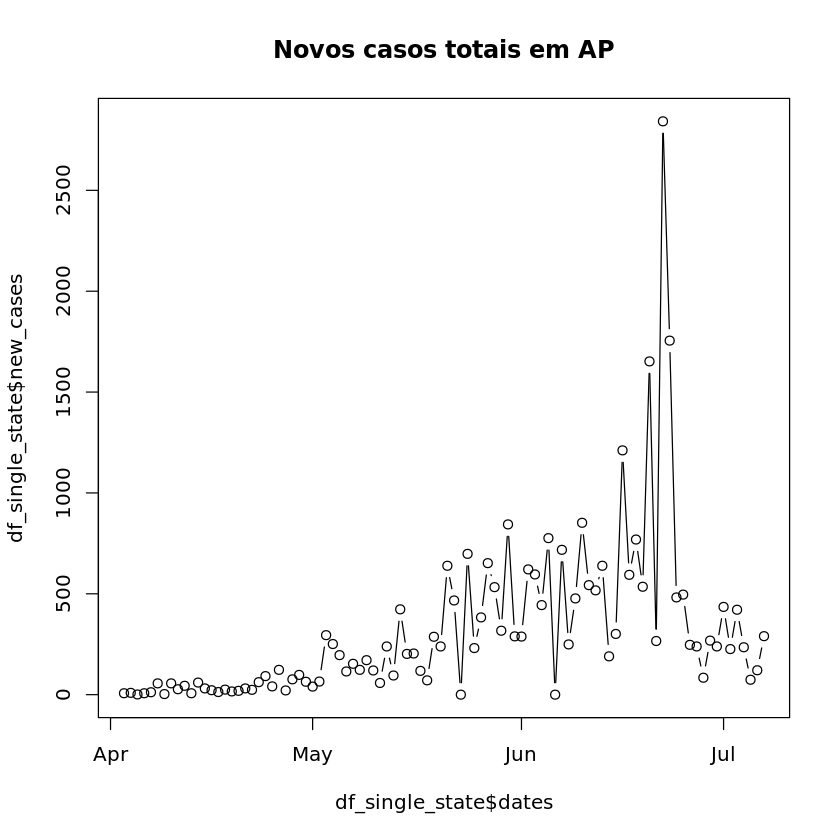

In [42]:
plot(x=df_single_state$dates ,
     y=df_single_state$new_cases, 
     type = "b",
     main="Novos casos totais em AP")